In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 
# Import necessary libraries
from sys import float_info  # Threshold smallest positive floating value
from math import ceil, floor 
import matplotlib.pyplot as plt # For general plotting
import numpy as np
from scipy.optimize import minimize
from scipy.stats import multivariate_normal as mvn
from sklearn.preprocessing import PolynomialFeatures

# Adjust display settings for readability
np.set_printoptions(suppress=True)

# Set a specific seed for reproducible results
np.random.seed(7)

# Customize font sizes for better visualization
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title

In [2]:
def generate_data1(N, pdf_params):
        # Determine dimensionality from mixture PDF parameters
  n = pdf_params['mo'].shape[1]
        # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
  u = np.random.rand(N)
        # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
  thresholds = np.cumsum(np.append(pdf_params['gmm_w'].dot(pdf_params['prior'][0]), pdf_params['prior'][1]))
  thresholds = np.insert(thresholds, 0, 0)
  labels = u >= pdf['prior'][0]
  X = np.zeros((N, n))
  guass = len(pdf_params['mo'])
  for i in range(0, guass):
    indice = np.argwhere((thresholds[i-1] <= u) & (u <= thresholds[i]))[:, 0]
    X[indice, :] = mvn.rvs(pdf['mo'][i-1], pdf['Co'][i-1], len(indice))
  return X, labels

In [3]:
def estimate_roc(d_score, labels, N_labels):
  sorted_score = sorted(d_score)
  gammas = ([sorted_score[0] - float_info.epsilon] + sorted_score + sorted_score[-1] + float_info.epsilon)
  decisions = [d_score >= g for g in gammas]
  ind10 = [np.argwhere((d==1) & (labels == 0)) for d in decisions]
  p10 = [len(inds) / N_labels[0] for inds in ind10]
  ind11 = [np.argwhere((d==1) & (labels == 1)) for d in decisions]
  p11 = [len(inds) / N_labels[1] for inds in ind11]
  roc = {
      'p10': np.array(p10),
      'p11': np.array(p11)
  }
  return roc, gammas

def get_binary_classification_metrics(predictions, labels, N_labels):
  class_metrics = {}
  class_metrics['TN'] = np.argwhere((predictions == 0) & (labels == 0))
  class_metrics['TNR'] = len(class_metrics['TN']) / N_labels[0]
  class_metrics['FP'] = np.argwhere((predictions == 1) & (labels == 0))
  class_metrics['FPR'] = len(class_metrics['FP']) / N_labels[0]
  class_metrics['FN'] = np.argwhere((predictions == 0) & (labels == 1))
  class_metrics['FNR'] = len(class_metrics['FN']) / N_labels[1]
  class_metrics['TP'] = np.argwhere((predictions == 1) & (labels == 1))
  class_metrics['TPR'] = len(class_metrics['TP']) / N_labels[1]

  return class_metrics

def prediction_score(X_bound, Y_bound, pdf, prediction_function, phi=None, num_cord=200):
  xx, yy = np.meshgrid(np.linspace(X_bound[0], X_bound[1], num_cord), np.linspace(Y_bound[0], Y_bound[1], num_cord))
  grid = np.c_[xx.ravel(), yy.ravel()]
  if phi:
    grid = phi.transform(grid)
  Z = prediction_function(grid, pdf).reshape(xx.shape)
  return xx, yy, Z

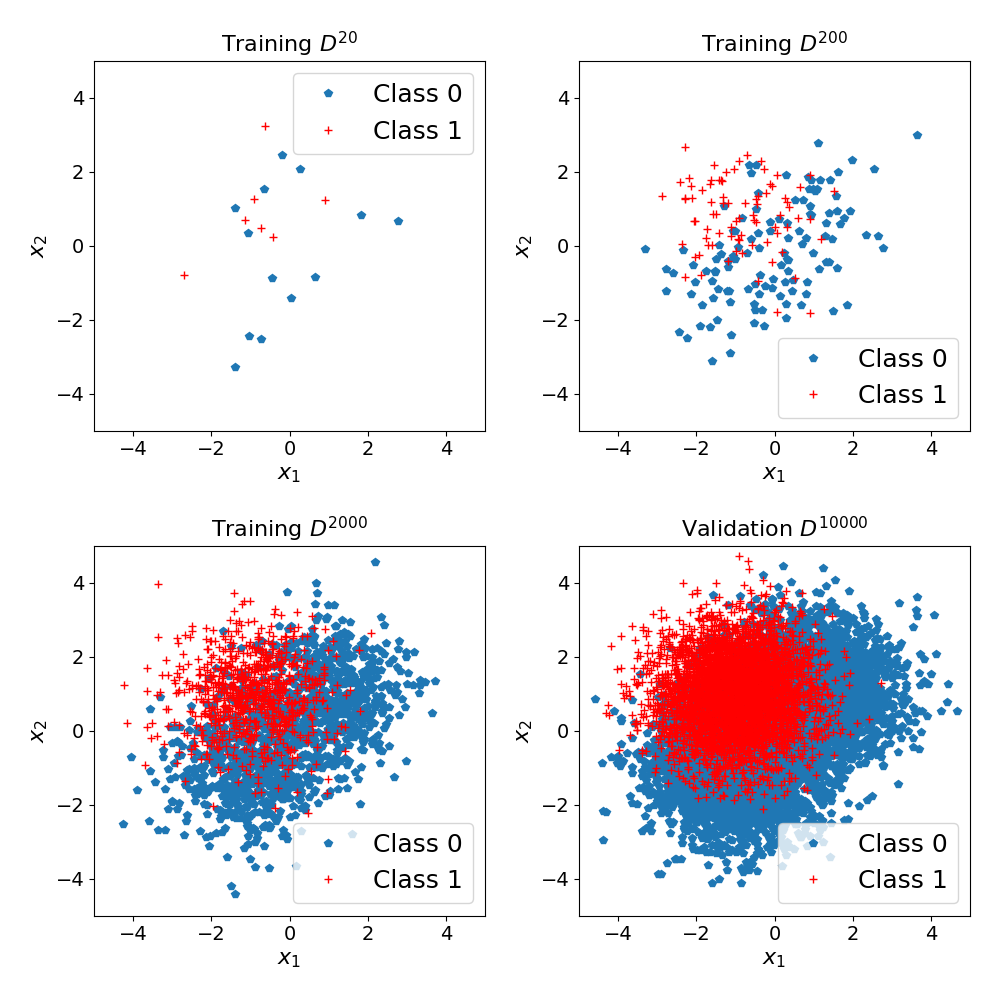

In [4]:
# Define distribution parameters: a, mu and Sigma
# Define distribution parameters: a, mu and Sigma
pdf = {
    'prior': np.array([0.6, 0.4]),
    'gmm_w': np.array([0.5, 0.5]),
    'mo': np.array([[-1, -1], [1, 1], [-1, 1], [1, -1]]),
    'Co': np.array([[[1,0], [0, 1]],
                    [[1,0], [0, 1]],
                    [[1,0], [0, 1]],
                    [[1,0], [0, 1]]])
}
    
# Number of training input samples for experiments
N_train = [20, 200, 2000]

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Making lists for the samples and labels
X_train = []
labels_train = []
N_labels_train = []
# Index for axes
t = 0
for N_t in N_train:
    X_t, labels_t = generate_data1(N_t, pdf)
    X_train.append(X_t)

    labels_train.append(labels_t)
    N_labels_train.append(np.array((sum(labels_t == 0), sum(labels_t == 1))))

    # Axis fancy indexing for the sake of plotting correctly in subplots
    ax[floor(t/2), t%2].set_title(r"Training $D^{%d}$" % (N_t))
    ax[floor(t/2), t%2].plot(X_t[labels_t==0, 0], X_t[labels_t==0, 1], 'p', label="Class 0")
    ax[floor(t/2), t%2].plot(X_t[labels_t==1, 0], X_t[labels_t==1, 1], 'r+', label="Class 1")
    ax[floor(t/2), t%2].set_xlabel(r"$x_1$")
    ax[floor(t/2), t%2].set_ylabel(r"$x_2$")
    ax[floor(t/2), t%2].legend()

    t += 1

# Number of validation samples for experiments
N_valid = 10000

X_valid, labels_valid = generate_data1(N_valid, pdf)

# Count up the number of samples per class
Nl_valid = np.array((sum(labels_valid == 0), sum(labels_valid == 1)))

ax[1, 1].set_title(r"Validation $D^{%d}$" % (N_valid))
ax[1, 1].plot(X_valid[labels_valid==0, 0], X_valid[labels_valid==0, 1], 'p', label="Class 0")
ax[1, 1].plot(X_valid[labels_valid==1, 0], X_valid[labels_valid==1, 1], 'r+', label="Class 1")
ax[1, 1].set_xlabel(r"$x_1$")
ax[1, 1].set_ylabel(r"$x_2$")
ax[1, 1].legend()

# Using validation set samples to limit axes (most samples drawn, highest odds of spanning sample space)
x1_valid_lim = (floor(np.min(X_valid[:,0])), ceil(np.max(X_valid[:,0])))
x2_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))
# Keep axis-equal so there is new skewed perspective due to a greater range along one axis
plt.setp(ax, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.tight_layout()
plt.show()



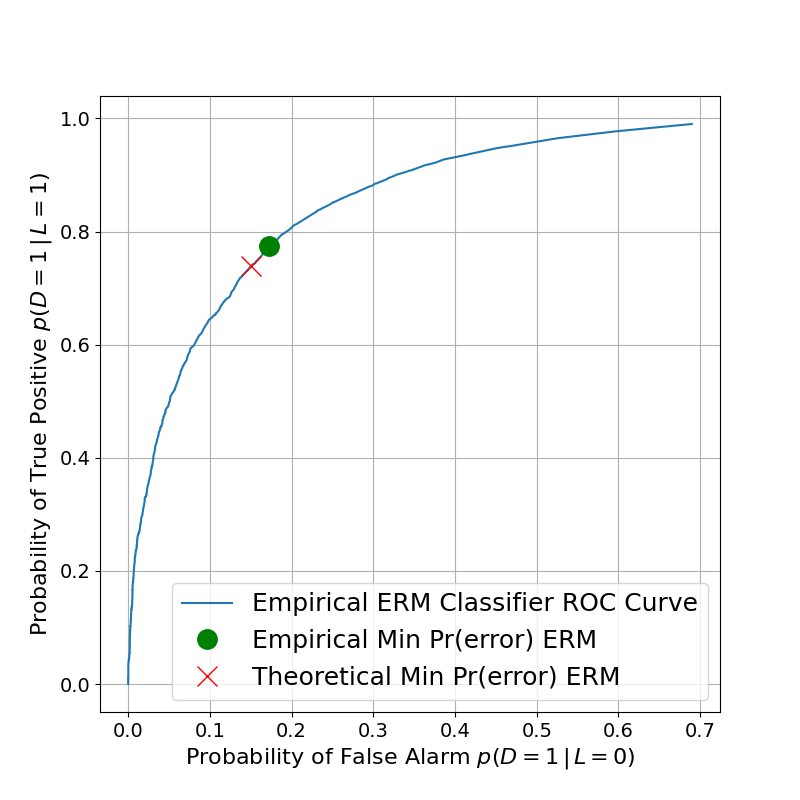

Min Empirical Pr(error) for ERM = 0.1940
Min Empirical Gamma = 1.273
Min Theoretical Pr(error) for ERM = 0.1948
Min Theoretical Gamma = 1.500


In [5]:
def discriminant_score_erm(X, dist_params):
    class_lld_0 = (dist_params['gmm_w'][0]*mvn.pdf(X, dist_params['mo'][0], dist_params['Co'][0])
                   + dist_params['gmm_w'][1]*mvn.pdf(X, dist_params['mo'][1], dist_params['Co'][1]))
    class_lld_1 = mvn.pdf(X, dist_params['mo'][2], dist_params['Co'][2])
    erm_scores = np.log(class_lld_1) - np.log(class_lld_0)
    return erm_scores

disc_erm_scores = discriminant_score_erm(X_valid, pdf)
roc_erm, gammas_empirical = estimate_roc(disc_erm_scores, labels_valid, Nl_valid)

fig_roc, ax_roc = plt.subplots(figsize=(8, 8));

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(Nl_valid / N_valid)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = pdf['prior'][0] / pdf['prior'][1]
decisions_map = disc_erm_scores >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels_valid, Nl_valid)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['FPR'] * pdf['prior'][0] + 
                               class_metrics_map['FNR'] * pdf['prior'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)

plt.grid(True)
plt.legend()
plt.show()

print("Min Empirical Pr(error) for ERM = {:.4f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.4f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

In [6]:
Epi = 1e-7

def logistic_prediction(X, w):
  logits = X.dot(w)
  y = 1 + np.exp(-logits)
  value = 1.0/y
  return value

def negative_log_likelihood(labels, predictions):
  predict1 = np.clip(predictions, Epi, 1-Epi)
  log_p0 = (1-labels)*np.log(1 - predict1 + Epi)
  log_p1 = labels * np.log(predict1 + Epi)
  return -np.mean(log_p0 + log_p1, axis=0)


In [7]:
def Compute_param_logistic(X, labels):
  theta0 = np.random.randn(X.shape[1])
  cost_fun = lambda w: negative_log_likelihood(labels, logistic_prediction(X, w))
  res = minimize(cost_fun, theta0, tol=1e-6)
  return res.x


In [8]:
def logistic_classifier(ax, X, w, labels, N_labels, phi=None):
  predictions = logistic_prediction(phi.fit_transform(X), w)
  decisions = np.array(predictions >= 0.5)
  logistic_metrics = get_binary_classification_metrics(decisions, labels, N_labels)
  probability_error = np.array((logistic_metrics['FPR'], logistic_metrics['FNR'])).T.dot(N_labels / labels.shape[0])
  ax.plot(X[logistic_metrics['TN'], 0], X[logistic_metrics['TN'], 1], 'og', label="Correct Class 0");
  ax.plot(X[logistic_metrics['FP'], 0], X[logistic_metrics['FP'], 1], 'or', label="Incorrect Class 0");
  ax.plot(X[logistic_metrics['FN'], 0], X[logistic_metrics['FN'], 1], '+r', label="Incorrect Class 1");
  ax.plot(X[logistic_metrics['TP'], 0], X[logistic_metrics['TP'], 1], '+g', label="Correct Class 1");
  xx, yy, Z = prediction_score(x1_valid_lim, x2_valid_lim, w, logistic_prediction, phi)
  cs = ax.contour(xx, yy, Z, levels=1, colors='k')
  ax.set_xlabel(r"$x_1$")
  ax.set_ylabel(r"$x_2$")
  return probability_error

Linear Logistic Model:
Linear Logistic Model for Train Sample = 20 MLE for w:  [-1.31163001 -0.9195603   0.61015452]
Training set error for Sample = 20 classifier error =  0.3000
Validation set error for Sample = 20 classifier error =  0.2451
Linear Logistic Model for Train Sample = 200 MLE for w:  [-1.1461896  -0.86736806  1.03785081]
Training set error for Sample = 200 classifier error =  0.2350
Validation set error for Sample = 200 classifier error =  0.2354
Linear Logistic Model for Train Sample = 2000 MLE for w:  [-1.4015308  -0.94160352  0.99618536]
Training set error for Sample = 20 classifier error =  0.2265
Validation set error for Sample = 20 classifier error =  0.2321


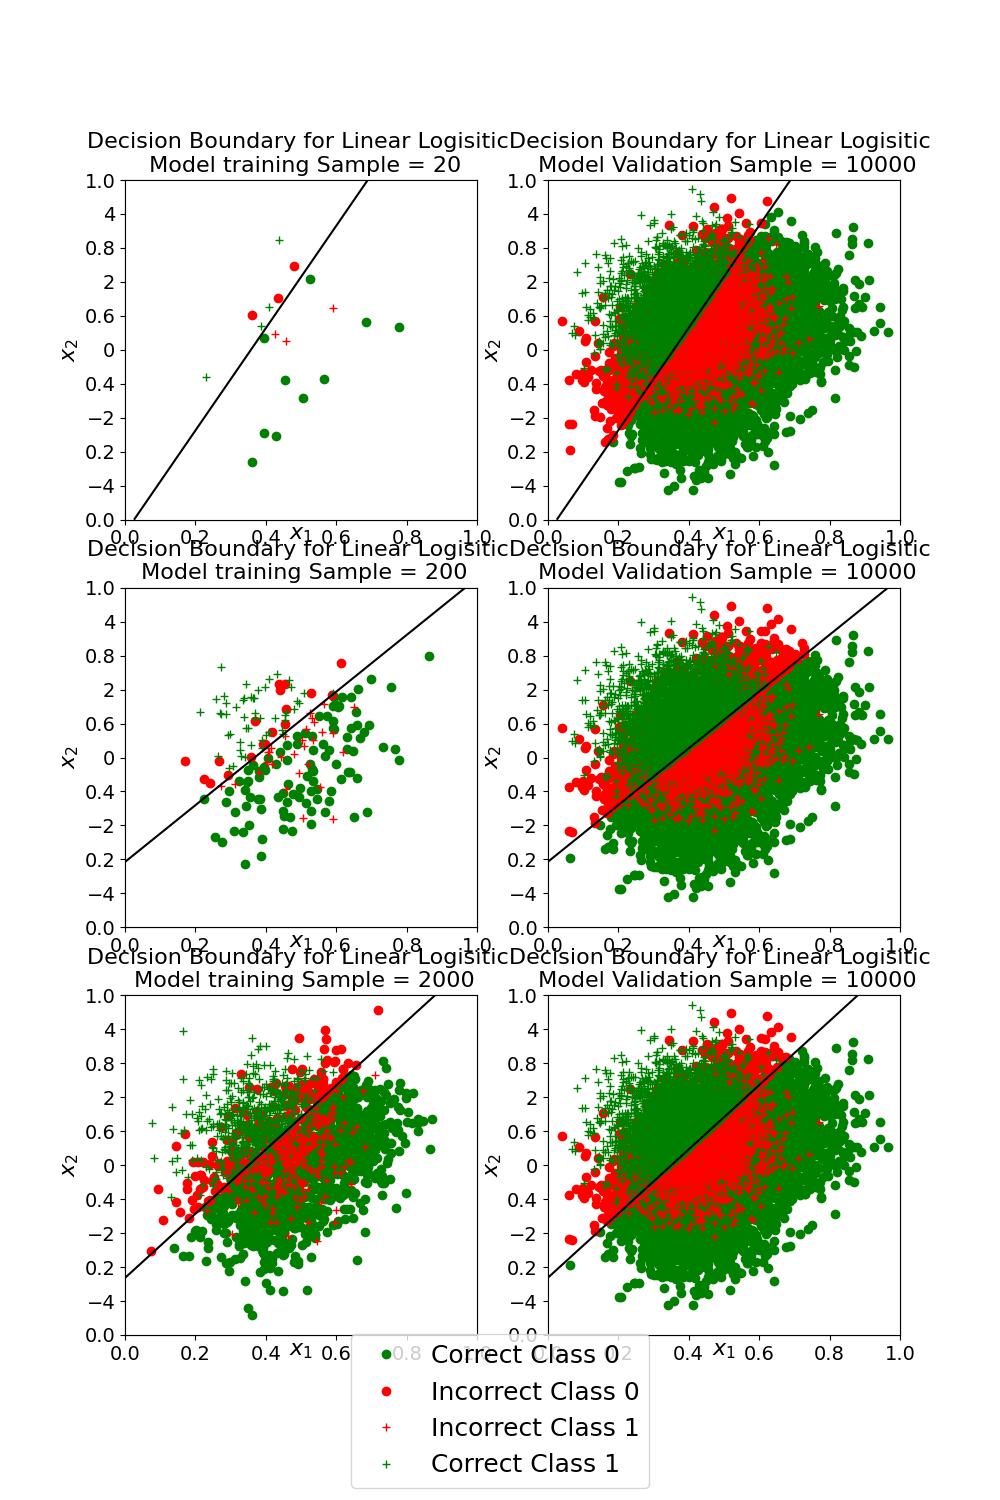

In [9]:
print("Linear Logistic Model:")
fig_linear, ax_linear = plt.subplots(3, 2, figsize=(10, 15));
ax_linear_20 = fig_linear.add_subplot(321)
ax_linear_200 = fig_linear.add_subplot(323)
ax_linear_2000 = fig_linear.add_subplot(325)
ax_linear_422 = fig_linear.add_subplot(322)
ax_linear_424 = fig_linear.add_subplot(324)
ax_linear_426 = fig_linear.add_subplot(326)
phi = PolynomialFeatures(degree=1)

# 20 samples
w_mle_20 = Compute_param_logistic(phi.fit_transform(X_train[0]), labels_train[0])
probability_error_20 = logistic_classifier(ax_linear_20, X_train[0], w_mle_20, labels_train[0], N_labels_train[0], phi)
probability_error_valid_20 = logistic_classifier(ax_linear_422, X_valid, w_mle_20, labels_valid, Nl_valid, phi)
print("Linear Logistic Model for Train Sample = 20 MLE for w: ", w_mle_20)
print("Training set error for Sample = 20 classifier error = ","{:.4f}".format(probability_error_20))
print("Validation set error for Sample = 20 classifier error = ", "{:.4f}".format(probability_error_valid_20))
ax_linear_20.set_title("Decision Boundary for Linear Logisitic \n Model training Sample = 20")
ax_linear_20.set_xticks([])
ax_linear_422.set_title("Decision Boundary for Linear Logisitic \n Model Validation Sample = 10000")
ax_linear_422.set_xticks([])

# 200 samples
w_mle_200 = Compute_param_logistic(phi.fit_transform(X_train[1]), labels_train[1])
probability_error_200 = logistic_classifier(ax_linear_200, X_train[1], w_mle_200, labels_train[1], N_labels_train[1], phi)
probability_error_valid_200 = logistic_classifier(ax_linear_424, X_valid, w_mle_200, labels_valid, Nl_valid, phi)
print("Linear Logistic Model for Train Sample = 200 MLE for w: ", w_mle_200)
print("Training set error for Sample = 200 classifier error = ","{:.4f}".format(probability_error_200))
print("Validation set error for Sample = 200 classifier error = ", "{:.4f}".format(probability_error_valid_200))
ax_linear_200.set_title("Decision Boundary for Linear Logisitic \n Model training Sample = 200")
ax_linear_200.set_xticks([])
ax_linear_424.set_title("Decision Boundary for Linear Logisitic \n Model Validation Sample = 10000")
ax_linear_424.set_xticks([])

# 2000 samples
w_mle_2000 = Compute_param_logistic(phi.fit_transform(X_train[2]), labels_train[2])
probability_error_2000 = logistic_classifier(ax_linear_2000, X_train[2], w_mle_2000, labels_train[2], N_labels_train[2], phi)
probability_error_valid_2000 = logistic_classifier(ax_linear_426, X_valid, w_mle_2000, labels_valid, Nl_valid, phi)
print("Linear Logistic Model for Train Sample = 2000 MLE for w: ", w_mle_2000)
print("Training set error for Sample = 20 classifier error = ","{:.4f}".format(probability_error_2000))
print("Validation set error for Sample = 20 classifier error = ", "{:.4f}".format(probability_error_valid_2000))
ax_linear_2000.set_title("Decision Boundary for Linear Logisitic \n Model training Sample = 2000")
ax_linear_2000.set_xticks([])
ax_linear_426.set_title("Decision Boundary for Linear Logisitic \n Model Validation Sample = 10000")
ax_linear_426.set_xticks([])

handles, labels = ax_linear_20.get_legend_handles_labels()
fig_linear.legend(handles, labels, loc='lower center')
plt.setp(ax_linear_20, xlim=x1_valid_lim, ylim=x2_valid_lim)
plt.savefig('linear_logistic.png')
plt.show()


In [10]:
def generate_data2(N, dataset_name):
    gmm_pdf = {}
    gmm_pdf['prior'] = np.array([.3, .4, .3])
    gmm_pdf['mo'] = np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]])  # Gaussian distributions means
    gmm_pdf['Co'] = np.array([[[1, 0, -3], [0, 1, 0], [-3, 0, 15]], [[8, 0, 0], [0, .5, 0], [0, 0, .5]],
                                 [[1, 0, -3], [0, 1, 0], [-3, 0, 15]]])  # Gaussian distributions covariance matrices

    X, y = generate_data_from_gmm(N, gmm_pdf)

    # Plot the original data and their true labels
    fig = plt.figure(figsize=(10, 10))

    ax_raw = fig.add_subplot(111, projection='3d')

    ax_raw.scatter(X[:, 0], X[:, 1], y, marker='o', color='b')
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_zlabel(r"$y$")
    # Set equal axes for 3D plots
    ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(y)))

    plt.title("{} Dataset".format(dataset_name))
    plt.tight_layout()
    plt.show()

    return X, y


def generate_data_from_gmm(N, gmm_pdf):
    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(gmm_pdf['prior'])
    thresholds = np.insert(thresholds, 0, 0)  # For intervals of classes

    n = gmm_pdf['mo'].shape[0]  # Data dimensionality

    X = np.zeros((N, n))
    C = len(gmm_pdf['prior'])  # Number of components
    for i in range(C + 1):
        # Get randomly sampled indices for this Gaussian, checking between thresholds based on class priors
        indices = np.argwhere((thresholds[i - 1] <= u) & (u <= thresholds[i]))[:, 0]
        # No. of samples in this Gaussian
        X[indices, :] = mvn.rvs(gmm_pdf['mo'][i - 1], gmm_pdf['Co'][i - 1], len(indices))

    return X[:, 0:2], X[:, 2]


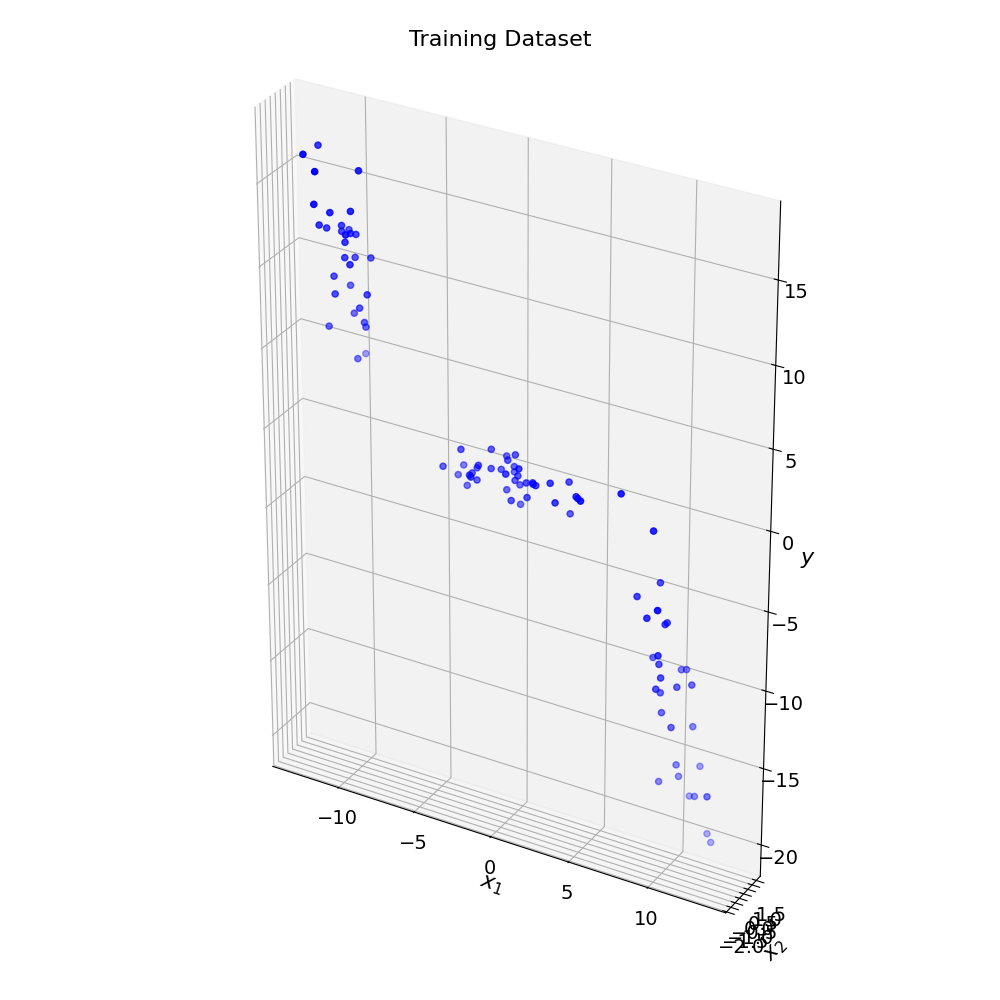

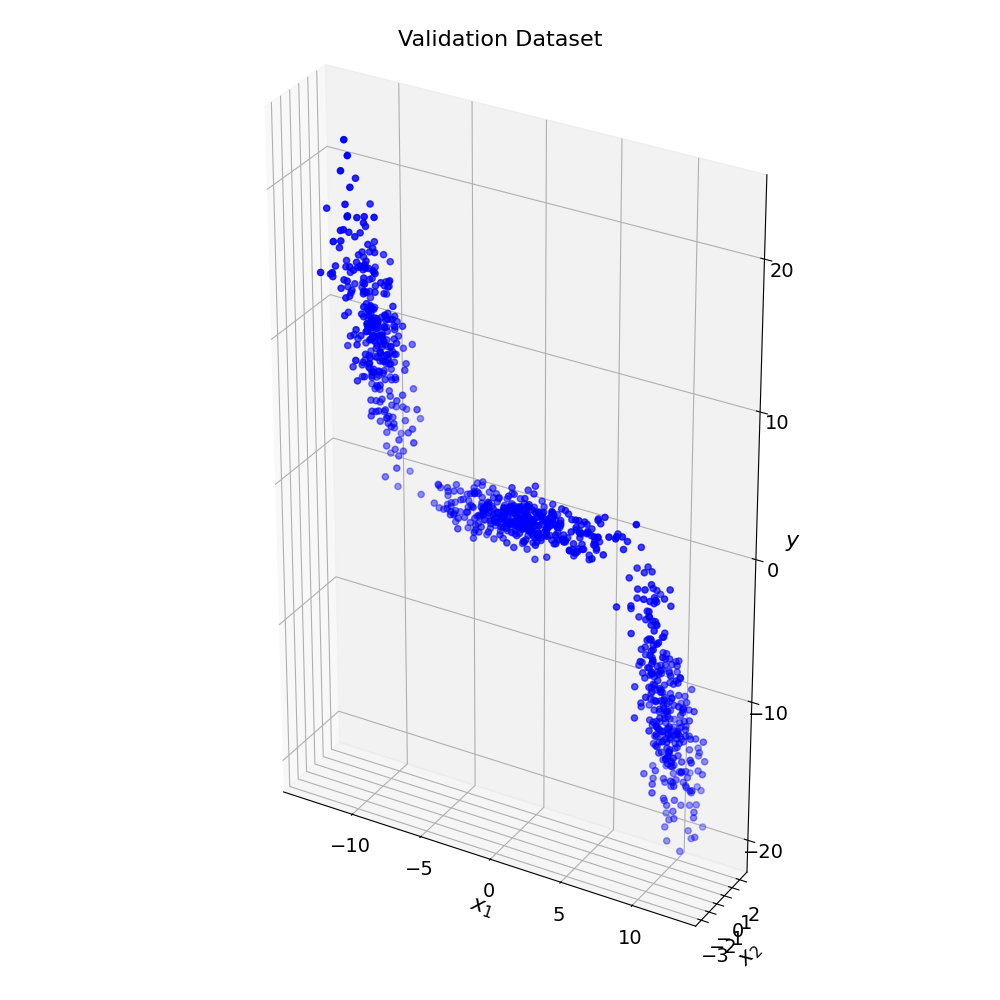

In [11]:
X_train, y_train = generate_data2(100, "Training")
X_valid, y_valid = generate_data2(1000, "Validation")

In [12]:
def mle_estimator(X,y):
    value = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return value

In [13]:
def map_estimator(X, y, gamma):
    value = np.linalg.inv(X.T.dot(X) + (1 / gamma)*np.eye(X.shape[1])).dot(X.T).dot(y)
    return value

In [14]:
def ase(y_pred, y_true):
    error = y_pred - y_true
    mean = np.mean(error ** 2)
    return mean

Average Squared-Error on Validation set for ML estimator =  6.4730


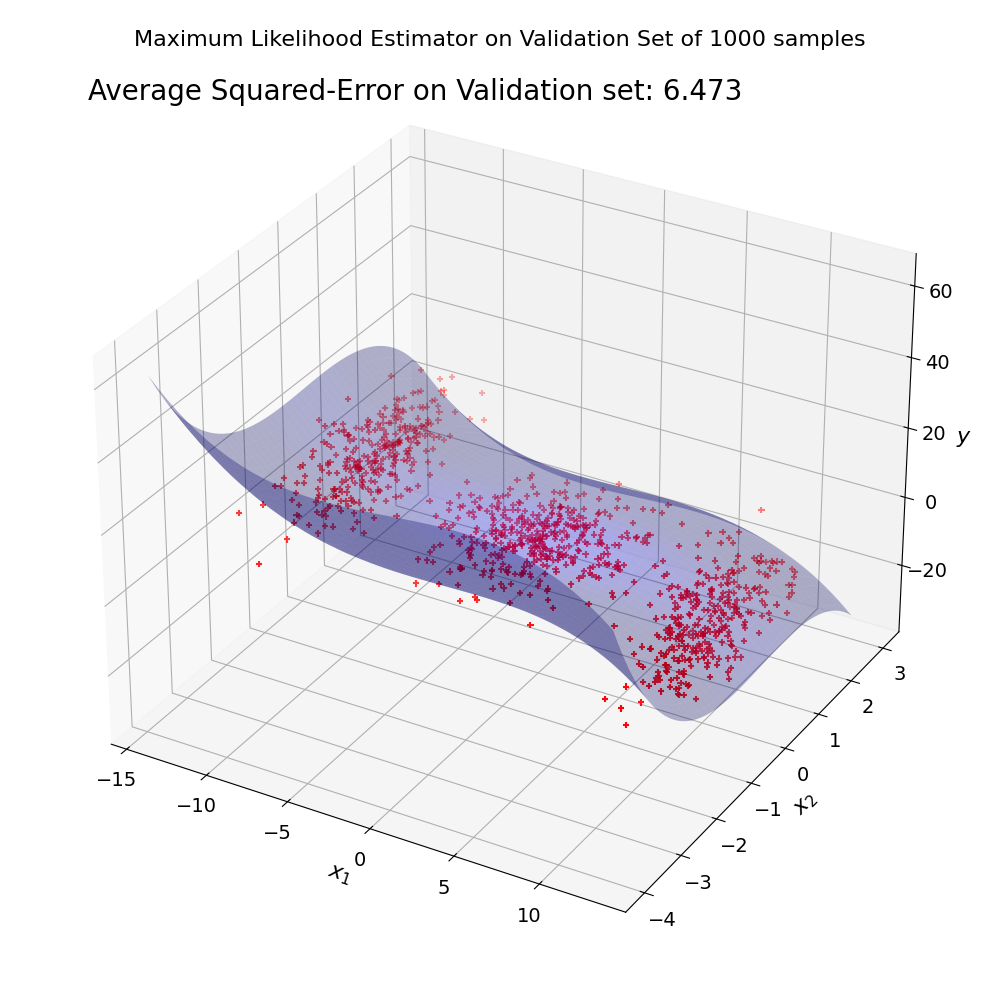

In [15]:
phi = PolynomialFeatures(degree=3)
X_train_cubic = phi.fit_transform(X_train)
theta_mle = mle_estimator(X_train_cubic, y_train)

X_valid_cubic = phi.transform(X_valid)
y_pred_mle = X_valid_cubic.dot(theta_mle)

ase_mle = ase(y_pred_mle, y_valid)
print("Average Squared-Error on Validation set for ML estimator = ", "{:.4f}".format(ase_mle))
x1_valid_lim = (floor(np.min(X_valid[:,0])), ceil(np.max(X_valid[:,0])))
x2_valid_lim = (floor(np.min(X_valid[:,1])), ceil(np.max(X_valid[:,1])))

reg_fun = lambda X, th: X.dot(th)
xx, yy, Z = prediction_score(x1_valid_lim, x2_valid_lim, theta_mle, reg_fun, phi, num_cord=100)

fig_mle = plt.figure(figsize=(10, 10))
ax_mle = fig_mle.add_subplot(111, projection ='3d')

# Plot the best fit plane on the 2D real vector samples
ax_mle.scatter(X_valid[:,0], X_valid[:,1], y_valid, marker='+', color='r')
ax_mle.plot_surface(xx, yy, Z, color='blue', alpha=0.3)
ax_mle.set_xlabel(r"$x_1$")
ax_mle.set_ylabel(r"$x_2$")
ax_mle.set_zlabel(r"$y$")
ax_mle.text2D(0.05, 0.95, "Average Squared-Error on Validation set: %.3f" % ase_mle, transform=ax_mle.transAxes)
plt.title("Maximum Likelihood Estimator on Validation Set of 1000 samples")
plt.tight_layout()
plt.savefig("Scatterplot_mlestimator.png")
plt.show()



Best Average Squared-Error for MAP estimator for gamma = 8.973315814583519e-07 is : 4.452


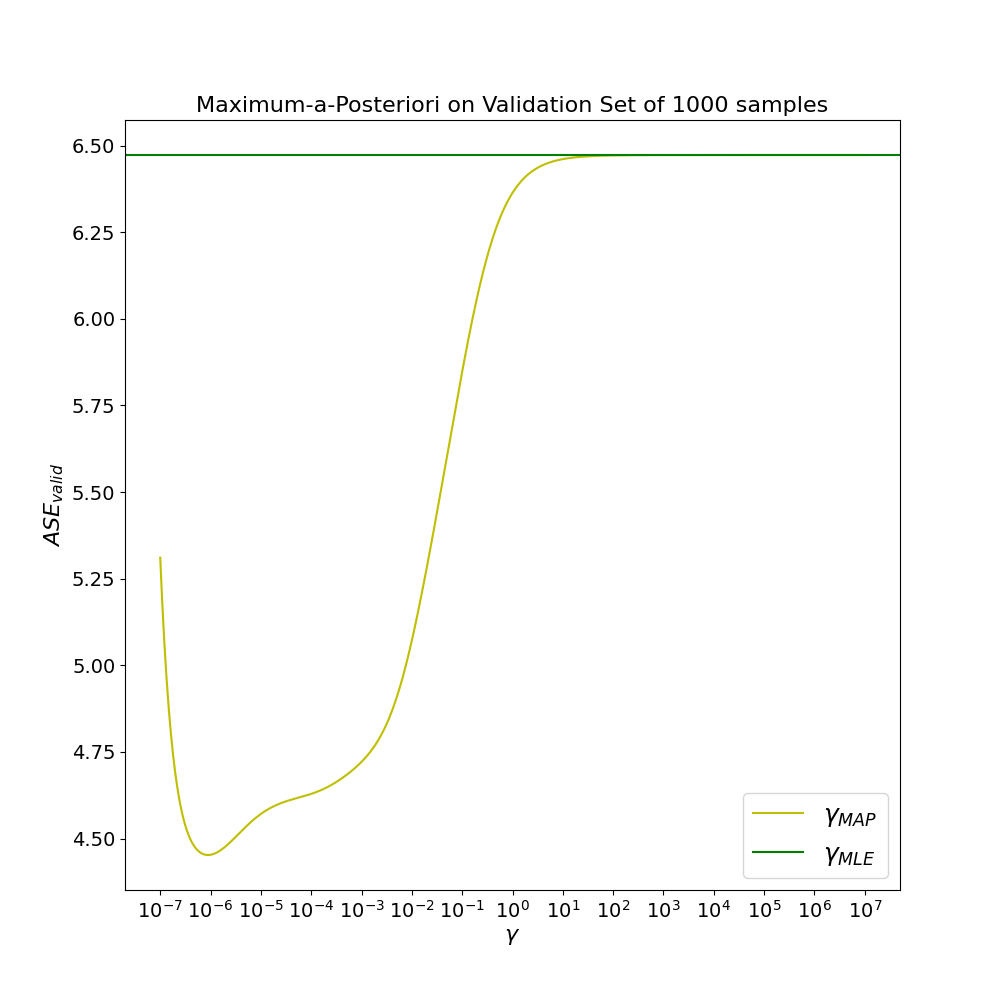

In [16]:
gamma_sample = 1000
gammas = np.geomspace(10**-7, 10**7, num=gamma_sample)
average_se_map = np.empty(gamma_sample) 
for i, gam in enumerate(gammas):
    Map_theta = map_estimator(X_train_cubic, y_train, gam)
    y_pred_map = X_valid_cubic.dot(Map_theta)
    average_se_map[i] = ase(y_pred_map, y_valid)

out_string = "Best Average Squared-Error for MAP estimator for gamma = " + str(gammas[np.argmin(average_se_map)]) + " is : " + str("{:.3f}".format(np.min(average_se_map)))
print(out_string)

fig_map = plt.figure(figsize=(10,10))
ax_map = fig_map.add_subplot(111)
ax_map.plot(gammas,average_se_map, color='y', label=r"$\gamma_{MAP}$")
plt.axhline(y=ase_mle, xmin=10**-7, xmax=10**7, color='green',label=r"$\gamma_{MLE}$")

ax_map.set_xscale('log')
ax_map.set_xticks(np.geomspace(10**-7, 10**7, num=15))

ax_map.set_xlabel(r"$\gamma$")
ax_map.set_ylabel(r"$ASE_{valid}$")
ax_map.set_title("Maximum-a-Posteriori on Validation Set of 1000 samples")
plt.savefig("Scatterplot_mapstimator.png")
plt.legend()
plt.show() 

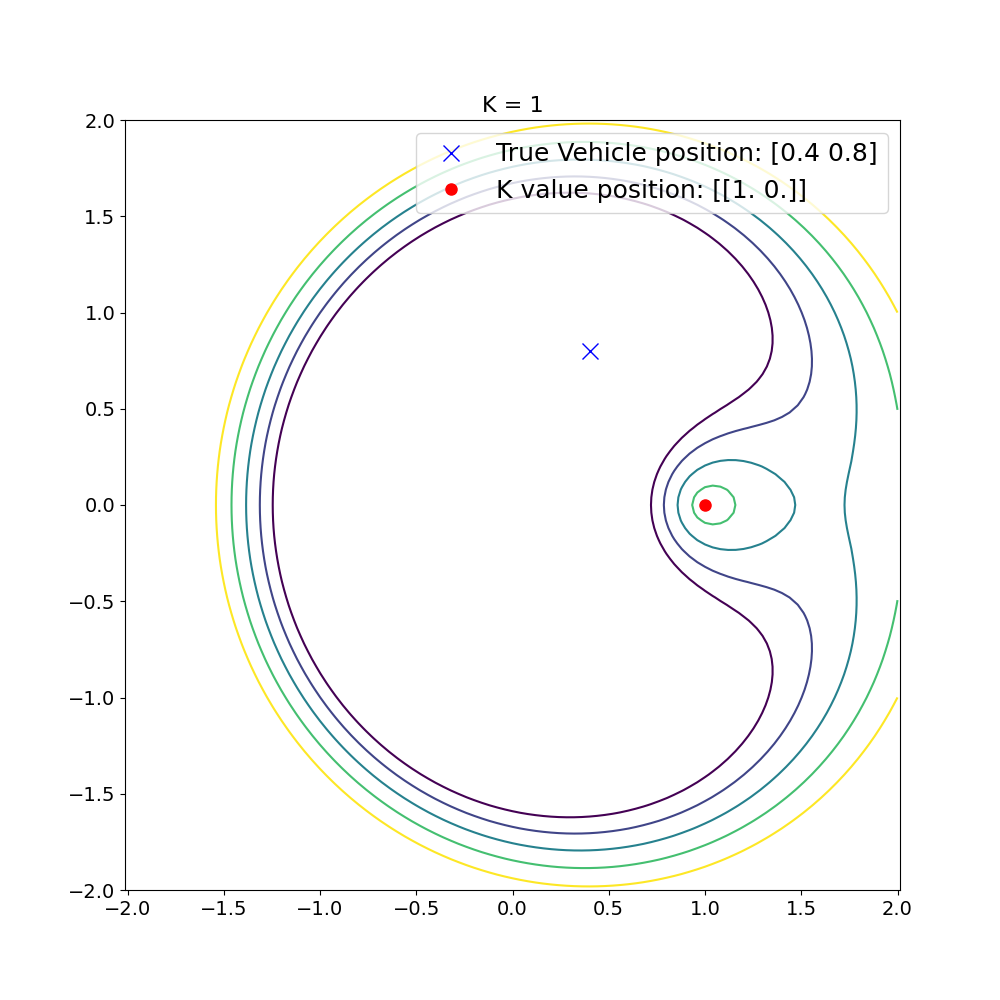

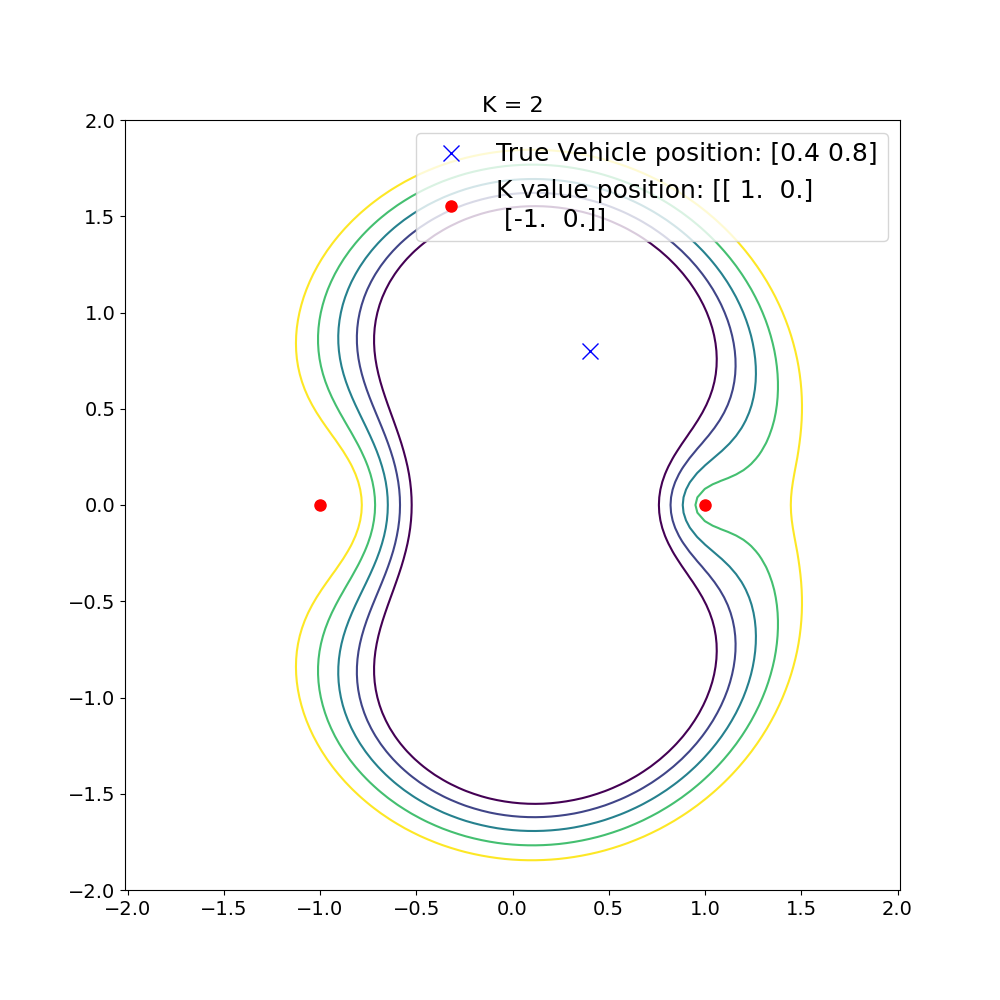

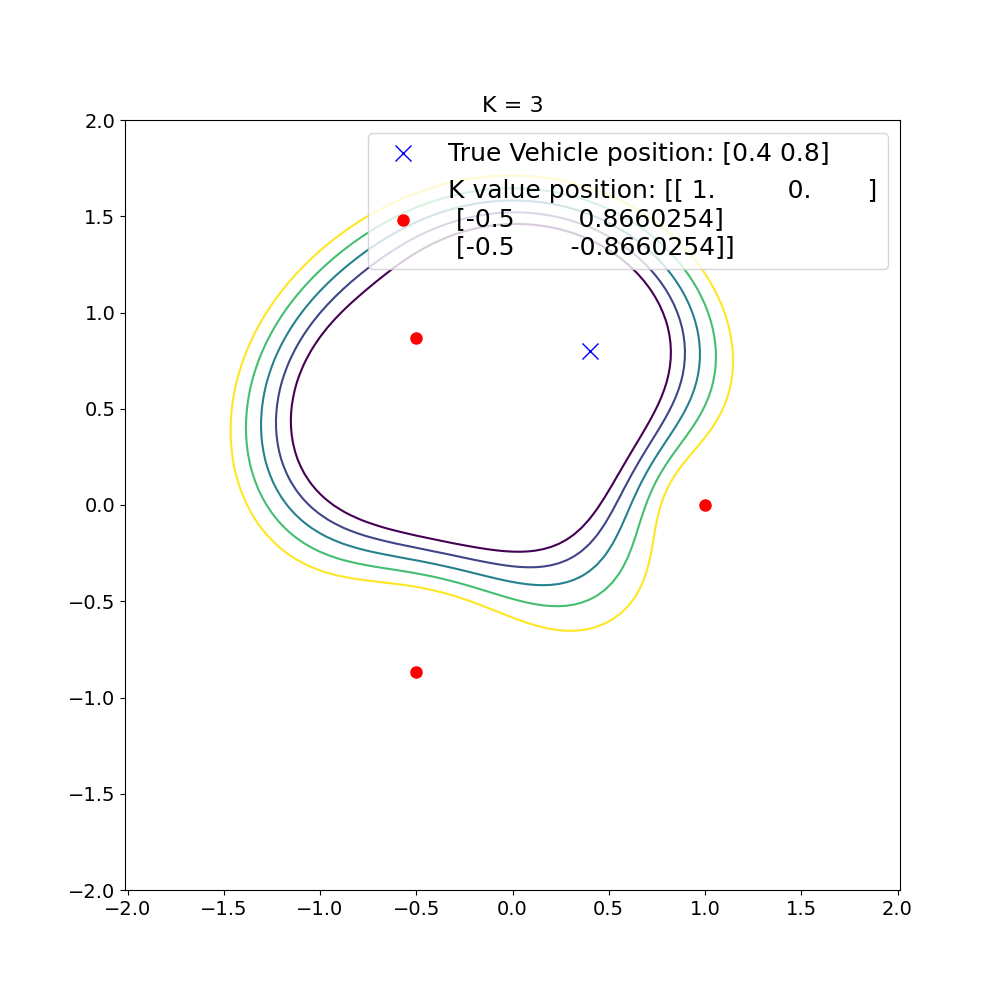

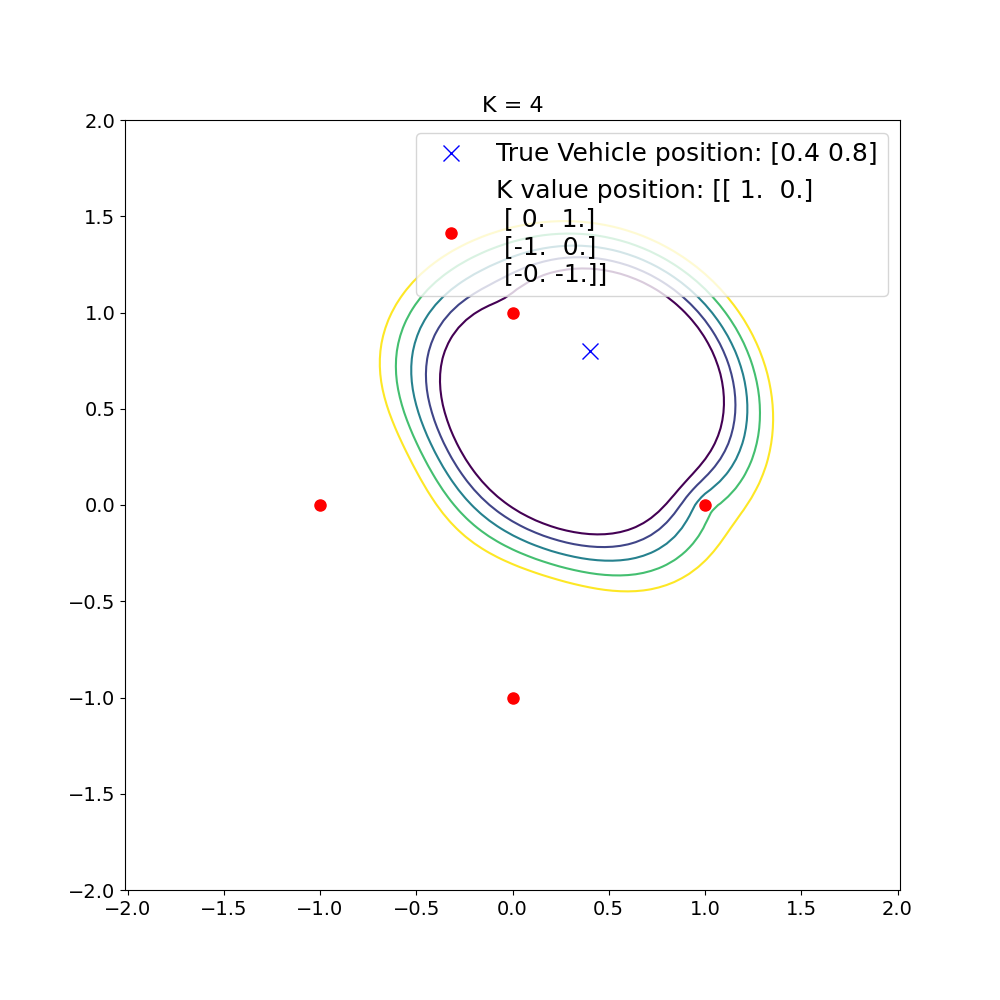

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# True position of Vehicle
true_vehicle_position = np.array([0.4, 0.8])

# Noise measurement range
noiserange = 0.3

# range measurement model
def range_model(point):
    value_1 = np.sqrt(np.sum((point - true_vehicle_position)**2)) + np.random.normal(0, noiserange)
    return value_1

# objective function for MAP estimator
def objective_function(point, landmark, ranges):
    prior = np.sum((point - np.array([0, 0]))**2) / 2
    error = np.sum((ranges - np.sqrt(np.sum((landmark - point)**2, axis=1)))**2)
    val = prior + error
    return val

# sample rejection measurement range
def sample_range(landmark):
    while True:
        sample = range_model(landmark)
        if sample >= 0:
            return sample

def plot_contour(K):
    # place landmarks on circle
    theta = np.linspace(0, 2*np.pi, K+1)[:-1]
    landmarks = np.array([np.cos(theta), np.sin(theta)]).T
    # Generate range
    ranges = np.array([sample_range(landmark) for landmark in landmarks])
    # Define range for coordinates
    x_range = y_range = np.linspace(-2, 2, 101)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    #Compute objective function
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            point = np.array([x_range[i], y_range[j]])
            Z[j, i] = objective_function(point, landmarks, ranges)
    
    # Plot contours of Objective Function
    plt.figure(figsize=(10, 10))
    levels = np.logspace(np.log10(3/2), np.log10(5/2), 5)
    plt.contour(X, Y, Z, levels=levels)
    plt.plot(true_vehicle_position[0], true_vehicle_position[1], 'bx', markersize=12, label=f'True Vehicle position: {true_vehicle_position}')
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'ro', markersize=8, label=f'K value position: {landmarks}')
    plt.axis('equal')
    plt.legend()
    plt.title(f'K = {K}')
    plt.savefig(f"K_{K}.png")
    plt.show()

for K in range(1,5):
    plot_contour(K)
